In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet

ƒê√£ t·∫£i m√¥ h√¨nh Prophet th√†nh c√¥ng!
‚úÖ T·∫£i scaler th√†nh c√¥ng: min=8.382509625943104, max=139.9770257564176
C√°c qu·∫≠n hi·ªán c√≥ trong m√¥ h√¨nh: ['Huy·ªán H√≤a Vang', 'Qu·∫≠n C·∫©m L·ªá', 'Qu·∫≠n H·∫£i Ch√¢u', 'Qu·∫≠n Li√™n Chi·ªÉu', 'Qu·∫≠n Ng≈© H√†nh S∆°n', 'Qu·∫≠n S∆°n Tr√†', 'Qu·∫≠n Thanh Kh√™']

ƒêang d·ª± b√°o gi√° cho Huy·ªán H√≤a Vang trong 90 ng√†y t·ªõi...

K·∫øt qu·∫£ d·ª± b√°o:
          Ng√†y            Qu·∫≠n  Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)  \
130 2025-04-10  Huy·ªán H√≤a Vang                   10.764896   
131 2025-04-11  Huy·ªán H√≤a Vang                   10.828874   
132 2025-04-12  Huy·ªán H√≤a Vang                   10.967943   
133 2025-04-13  Huy·ªán H√≤a Vang                   11.083236   
134 2025-04-14  Huy·ªán H√≤a Vang                   11.226631   
135 2025-04-15  Huy·ªán H√≤a Vang                   11.025756   
136 2025-04-16  Huy·ªán H√≤a Vang                   11.047701   
137 2025-04-17  Huy·ªán H√≤a Vang                   11.386368   

<Figure size 1400x800 with 0 Axes>

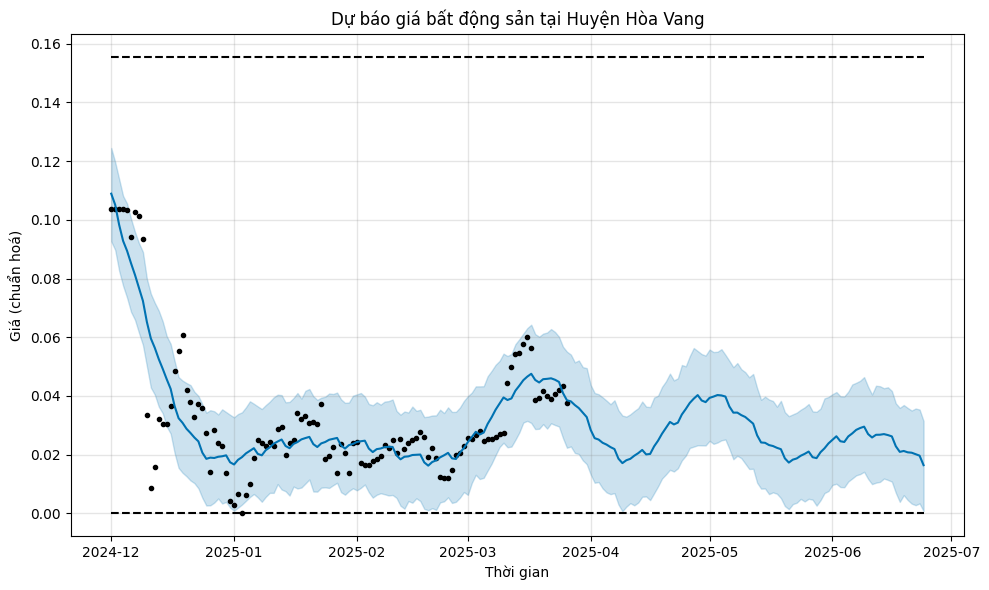

<Figure size 1400x800 with 0 Axes>

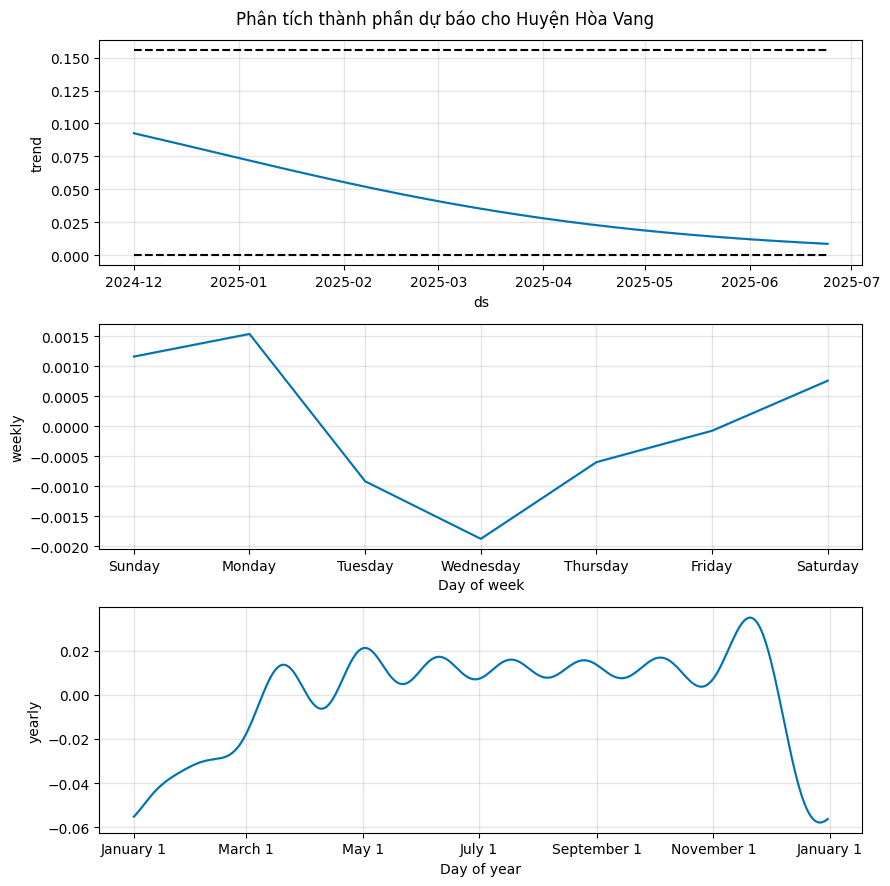

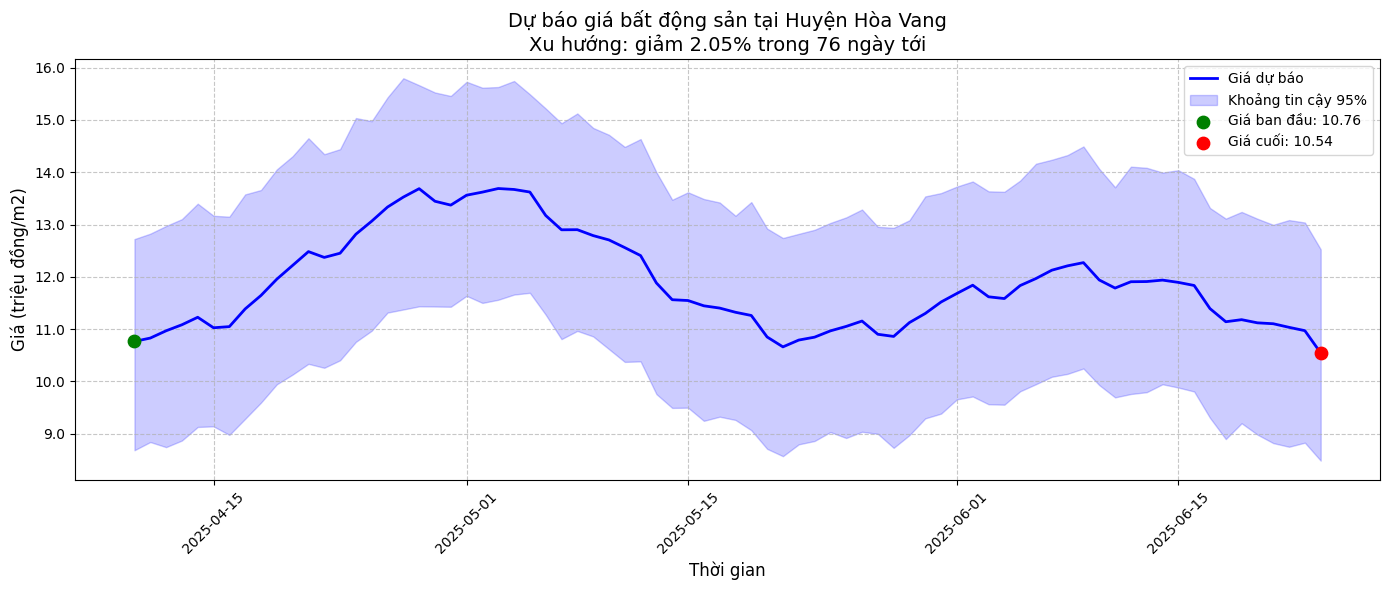


Ph√¢n t√≠ch xu h∆∞·ªõng gi√°:
‚Ä¢ Gi√° trung b√¨nh d·ª± b√°o: 11.89 tri·ªáu ƒë·ªìng/m2
‚Ä¢ Gi√° th·∫•p nh·∫•t d·ª± b√°o: 10.54 tri·ªáu ƒë·ªìng/m2
‚Ä¢ Gi√° cao nh·∫•t d·ª± b√°o: 13.69 tri·ªáu ƒë·ªìng/m2
‚Ä¢ Thay ƒë·ªïi gi√° trong 90 ng√†y: -2.05%

üóì Gi√° trung b√¨nh theo th√°ng:
‚Ä¢ Th√°ng 2025-04: 12.13 tri·ªáu ƒë·ªìng/m2
‚Ä¢ Th√°ng 2025-05: 11.94 tri·ªáu ƒë·ªìng/m2
‚Ä¢ Th√°ng 2025-06: 11.62 tri·ªáu ƒë·ªìng/m2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
from prophet import Prophet

# --- ƒê·ªçc th√¥ng s·ªë chu·∫©n ho√° t·ª´ file (Min-Max) ---
def load_scaler_params(filepath='predict_scaler_params.csv'):
    df = pd.read_csv(filepath)
    df.set_index('Metric', inplace=True)
    min_val = df.loc['min', 'price']
    max_val = df.loc['max', 'price']
    return min_val, max_val

# --- Ngh·ªãch chu·∫©n ho√° (Min-Max) ---
def inverse_scale(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

# --- H√†m d·ª± b√°o gi√° b·∫•t ƒë·ªông s·∫£n ---
def forecast_future_prices(district_name, model, periods=90, freq='D', min_val=None, max_val=None):
    # T·∫°o dataframe cho d·ª± b√°o t∆∞∆°ng lai
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    # N·∫øu s·ª≠ d·ª•ng logistic growth, th√™m cap v√† floor
    if hasattr(model, 'growth') and model.growth == 'logistic':
        if hasattr(model, 'history') and 'cap' in model.history:
            future['cap'] = model.history['cap'].max()
        else:
            # N·∫øu kh√¥ng c√≥ cap trong history, t·∫°o cap l√† 1.0 (gi√° tr·ªã chu·∫©n h√≥a t·ªëi ƒëa)
            future['cap'] = 1.0
        future['floor'] = 0.0    # ƒê·∫£m b·∫£o kh√¥ng c√≥ gi√° tr·ªã √¢m
    
    # D·ª± b√°o
    forecast = model.predict(future)
    
    # ƒê·∫£m b·∫£o kh√¥ng c√≥ gi√° tr·ªã √¢m (ngay c·∫£ khi kh√¥ng d√πng logistic growth)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    # L·ªçc ra c√°c d·ª± b√°o t∆∞∆°ng lai
    today = pd.Timestamp(datetime.now().strftime('%Y-%m-%d'))
    future_forecast = forecast[forecast['ds'] >= today].copy()

    # Ngh·ªãch chu·∫©n ho√° b·∫±ng Min-Max
    if min_val is not None and max_val is not None:
        future_forecast['yhat'] = inverse_scale(future_forecast['yhat'], min_val, max_val)
        future_forecast['yhat_lower'] = inverse_scale(future_forecast['yhat_lower'], min_val, max_val)
        future_forecast['yhat_upper'] = inverse_scale(future_forecast['yhat_upper'], min_val, max_val)

    # T·∫°o dataframe k·∫øt qu·∫£
    result_df = pd.DataFrame({
        'Ng√†y': future_forecast['ds'],
        'Qu·∫≠n': district_name,
        'Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)': future_forecast['yhat'],
        'Gi√° th·∫•p nh·∫•t (tri·ªáu ƒë·ªìng/m2)': future_forecast['yhat_lower'],
        'Gi√° cao nh·∫•t (tri·ªáu ƒë·ªìng/m2)': future_forecast['yhat_upper']
    })

    return result_df, forecast

# --- V·∫Ω bi·ªÉu ƒë·ªì chu·∫©n Prophet ---
def plot_forecast(model, forecast, district_name):
    """
    V·∫Ω bi·ªÉu ƒë·ªì d·ª± b√°o chu·∫©n c·ªßa Prophet
    
    Parameters:
    model (Prophet): M√¥ h√¨nh Prophet ƒë√£ hu·∫•n luy·ªán
    forecast (DataFrame): K·∫øt qu·∫£ d·ª± b√°o t·ª´ model.predict()
    district_name (str): T√™n qu·∫≠n/huy·ªán
    """
    plt.figure(figsize=(14, 8))
    fig = model.plot(forecast)
    plt.title(f'D·ª± b√°o gi√° b·∫•t ƒë·ªông s·∫£n t·∫°i {district_name}')
    plt.xlabel('Th·ªùi gian')
    plt.ylabel('Gi√° (chu·∫©n ho√°)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # V·∫Ω c√°c th√†nh ph·∫ßn c·ªßa m√¥ h√¨nh
    plt.figure(figsize=(14, 8))
    fig = model.plot_components(forecast)
    plt.suptitle(f'Ph√¢n t√≠ch th√†nh ph·∫ßn d·ª± b√°o cho {district_name}')
    plt.tight_layout()
    plt.show()

# --- V·∫Ω bi·ªÉu ƒë·ªì t√πy ch·ªânh (gi√° th·ª±c) ---
def plot_custom_forecast(result_df, district_name):
    """
    V·∫Ω bi·ªÉu ƒë·ªì t√πy ch·ªânh v·ªõi gi√° ƒë√£ ngh·ªãch chu·∫©n ho√°
    
    Parameters:
    result_df (DataFrame): DataFrame ch·ª©a k·∫øt qu·∫£ d·ª± b√°o ƒë√£ ngh·ªãch chu·∫©n ho√°
    district_name (str): T√™n qu·∫≠n/huy·ªán
    """
    plt.figure(figsize=(14, 6))
    
    # V·∫Ω ƒë∆∞·ªùng d·ª± b√°o ch√≠nh
    plt.plot(result_df['Ng√†y'], result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'], 
             'b-', linewidth=2, label='Gi√° d·ª± b√°o')
    
    # V·∫Ω kho·∫£ng tin c·∫≠y
    plt.fill_between(
        result_df['Ng√†y'],
        result_df['Gi√° th·∫•p nh·∫•t (tri·ªáu ƒë·ªìng/m2)'],
        result_df['Gi√° cao nh·∫•t (tri·ªáu ƒë·ªìng/m2)'],
        color='blue', alpha=0.2, label='Kho·∫£ng tin c·∫≠y 95%'
    )
    
    # ƒê√°nh d·∫•u gi√° ban ƒë·∫ßu v√† gi√° cu·ªëi
    first_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].iloc[0]
    last_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].iloc[-1]
    
    plt.scatter(result_df['Ng√†y'].iloc[0], first_price, color='green', s=80, zorder=5, 
                label=f'Gi√° ban ƒë·∫ßu: {first_price:.2f}')
    plt.scatter(result_df['Ng√†y'].iloc[-1], last_price, color='red', s=80, zorder=5, 
                label=f'Gi√° cu·ªëi: {last_price:.2f}')
    
    # T√≠nh ph·∫ßn trƒÉm thay ƒë·ªïi
    price_change_pct = ((last_price - first_price) / first_price) * 100
    change_direction = "tƒÉng" if price_change_pct >= 0 else "gi·∫£m"
    
    # Ti√™u ƒë·ªÅ v√† nh√£n
    plt.title(f'D·ª± b√°o gi√° b·∫•t ƒë·ªông s·∫£n t·∫°i {district_name}\n'
              f'Xu h∆∞·ªõng: {change_direction} {abs(price_change_pct):.2f}% trong '
              f'{len(result_df)} ng√†y t·ªõi', fontsize=14)
    plt.xlabel('Th·ªùi gian', fontsize=12)
    plt.ylabel('Gi√° (tri·ªáu ƒë·ªìng/m2)', fontsize=12)
    
    # ƒê·ªãnh d·∫°ng tr·ª•c v√† l∆∞·ªõi
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    
    # ƒê·ªãnh d·∫°ng tr·ª•c y ƒë·ªÉ hi·ªÉn th·ªã s·ªë ti·ªÅn
    from matplotlib.ticker import FuncFormatter
    def millions_formatter(x, pos):
        return f'{x:,.1f}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    
    # Hi·ªÉn th·ªã ch√∫ th√≠ch
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# --- Ch∆∞∆°ng tr√¨nh ch√≠nh ---
def main():
    # --- T·∫£i m√¥ h√¨nh Prophet ---
    try:
        with open('district_prophet_models.pkl', 'rb') as f:
            district_models = pickle.load(f)
        print("ƒê√£ t·∫£i m√¥ h√¨nh Prophet th√†nh c√¥ng!")
    except Exception as e:
        print(f"L·ªói khi t·∫£i m√¥ h√¨nh: {e}")
        return

    # --- T·∫£i scaler Min-Max ---
    try:
        min_val, max_val = load_scaler_params('predict_scaler_params.csv')
        print(f"‚úÖ T·∫£i scaler th√†nh c√¥ng: min={min_val}, max={max_val}")
    except Exception as e:
        print(f"L·ªói khi t·∫£i scaler: {e}")
        return

    # --- L·∫•y danh s√°ch qu·∫≠n ---
    available_districts = list(district_models.keys())
    print(f"C√°c qu·∫≠n hi·ªán c√≥ trong m√¥ h√¨nh: {available_districts}")

    # --- Ch·ªçn qu·∫≠n ƒë·ªÉ d·ª± b√°o ---
    district_name = available_districts[0]  # s·ª≠a th√†nh t√™n qu·∫≠n mong mu·ªën n·∫øu c·∫ßn
    prophet_model = district_models[district_name]
    periods = 90  # s·ªë ng√†y d·ª± b√°o

    print(f"\nƒêang d·ª± b√°o gi√° cho {district_name} trong {periods} ng√†y t·ªõi...")

    # --- Ki·ªÉm tra v√† c·∫≠p nh·∫≠t model growth n·∫øu c·∫ßn ---
    # L∆∞u √Ω: C·∫≠p nh·∫≠t n√†y ch·ªâ √°p d·ª•ng cho l·∫ßn ch·∫°y hi·ªán t·∫°i, kh√¥ng l√†m thay ƒë·ªïi model ƒë√£ l∆∞u
    if not hasattr(prophet_model, 'growth') or prophet_model.growth != 'logistic':
        print("ƒêang chuy·ªÉn m√¥ h√¨nh sang logistic growth ƒë·ªÉ tr√°nh d·ª± b√°o gi√° √¢m...")
        # Copy v√† chuy·ªÉn ƒë·ªïi model - ch·ªâ √°p d·ª•ng cho l·∫ßn d·ª± b√°o n√†y
        # Trong th·ª±c t·∫ø, n√™n hu·∫•n luy·ªán l·∫°i m√¥ h√¨nh v·ªõi logistic growth
        prophet_model.growth = 'logistic'

    # --- D·ª± b√°o ---
    result_df, forecast = forecast_future_prices(
        district_name,
        prophet_model,
        periods=periods,
        min_val=min_val,
        max_val=max_val
    )

    # --- In k·∫øt qu·∫£ ---
    print("\nK·∫øt qu·∫£ d·ª± b√°o:")
    print(result_df.head(10))

    # --- Xu·∫•t CSV ---
    today = datetime.now().strftime('%Y-%m-%d')
    end_date = (datetime.now() + timedelta(days=periods)).strftime('%Y-%m-%d')
    csv_filename = f"{district_name}_prophet_forecast_{today}_to_{end_date}.csv"
    result_df.to_csv(csv_filename, index=False)
    print(f"\nƒê√£ l∆∞u k·∫øt qu·∫£ d·ª± b√°o v√†o file: {csv_filename}")

    # --- V·∫Ω bi·ªÉu ƒë·ªì ---
    plot_forecast(prophet_model, forecast, district_name)
    plot_custom_forecast(result_df, district_name)

    # --- Ph√¢n t√≠ch xu h∆∞·ªõng ---
    avg_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].mean()
    min_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].min()
    max_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].max()

    first_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].iloc[0]
    last_price = result_df['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].iloc[-1]
    price_change = ((last_price - first_price) / first_price) * 100

    print("\nPh√¢n t√≠ch xu h∆∞·ªõng gi√°:")
    print(f"‚Ä¢ Gi√° trung b√¨nh d·ª± b√°o: {avg_price:,.2f} tri·ªáu ƒë·ªìng/m2")
    print(f"‚Ä¢ Gi√° th·∫•p nh·∫•t d·ª± b√°o: {min_price:,.2f} tri·ªáu ƒë·ªìng/m2")
    print(f"‚Ä¢ Gi√° cao nh·∫•t d·ª± b√°o: {max_price:,.2f} tri·ªáu ƒë·ªìng/m2")
    print(f"‚Ä¢ Thay ƒë·ªïi gi√° trong {periods} ng√†y: {price_change:.2f}%")

    # --- Trung b√¨nh theo th√°ng ---
    result_df['Th√°ng'] = result_df['Ng√†y'].dt.to_period('M')
    monthly_avg = result_df.groupby('Th√°ng')['Gi√° d·ª± b√°o (tri·ªáu ƒë·ªìng/m2)'].mean()

    print("\nüóì Gi√° trung b√¨nh theo th√°ng:")
    for month, price in monthly_avg.items():
        print(f"‚Ä¢ Th√°ng {month}: {price:,.2f} tri·ªáu ƒë·ªìng/m2")

# --- Ch·∫°y ch∆∞∆°ng tr√¨nh ---
if __name__ == "__main__":
    main()